# Setup

In [1]:
!pip install datatable==0.11.0 > /dev/null

In [2]:
import datatable as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [3]:
# Read data
pd_data = dt.fread('../input/train.csv').to_pandas()
pd_test = pd.read_csv('../input/example_test.csv')
#pd_feats = pd.read_csv('../input/features.csv')
#pd_pred = pd.read_csv('../input/example_sample_submission.csv')

# Train-Validation Split

In [4]:
i = int(pd_data.shape[0] * 0.05)
pd_train = pd_data.iloc[:-i, :]
pd_valid = pd_data.iloc[-i:, :]

print("n train: {}".format(pd_train.shape[0]))
print("n valid: {}".format(pd_valid.shape[0]))
print("n test:  {}".format(pd_test.shape[0]))

n train: 2270967
n valid: 119524
n test:  15219


# Preprocess

In [5]:
# Utilties
def filter_rows_with_zero_weight(pd_df):
    return pd_df.loc[pd_df.weight != 0]


def filter_rows_after_day_85(pd_df):
    return pd_df.loc[pd_df.date > 85]


def fill_missing_values(pd_df):
    return pd_df.fillna(-999)


def create_action_col(pd_df):
    return pd_df.assign(action=
        (((pd_df.weight * pd_df.resp) > 0).astype('int')))
                        

def convert_dtypes(pd_df):
    return pd_df.astype(
        {col: np.float32 for col in pd_df.select_dtypes(include='float64').columns})

In [6]:
# Preprocess data
pd_train = (pd_train
    .pipe(filter_rows_with_zero_weight)
    .pipe(filter_rows_after_day_85)
    .pipe(fill_missing_values)
    .pipe(create_action_col)
    .pipe(convert_dtypes))

pd_valid = (pd_valid
    .pipe(filter_rows_with_zero_weight)
    .pipe(fill_missing_values)
    .pipe(create_action_col)
    .pipe(convert_dtypes))

pd_test = (pd_test
    .pipe(filter_rows_with_zero_weight)
    .pipe(fill_missing_values)
    .pipe(convert_dtypes))

In [7]:
# Save
pd_train.to_parquet("./data/clean/train.parquet")
pd_valid.to_parquet("./data/clean/valid.parquet")
pd_test.to_parquet("./data/clean/test.parquet")

In [ ]:
# Read
pd_train = pd.read_parquet("./data/clean/train.parquet")
pd_valid = pd.read_parquet("./data/clean/valid.parquet")
pd_test = pd.read_parquet("./data/clean/test.parquet")

In [8]:
# (Optional) Free memory
del pd_data

# EDA

In [9]:
display(pd_train.head())
pd_train.info()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
527894,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,1,3.151305,5.467693,-0.164505,-0.189219,0.663966,0.988896,-999.0,-999.0,2.184804,3.278742,-999.0,-999.0,1.471544,2.391430,1.640887,3.938759,-999.0,-999.0,2.361346,4.711640,-999.0,-999.0,1.958027,4.069699,2.535239,4.813858,-999.0,-999.0,-0.194392,-0.336857,-999.0,-999.0,-0.073242,-0.131142,-0.197839,-0.288336,0.341815,0.599994,-0.202268,-0.471068,-0.405654,0.052440,-1.349263,-0.633717,-0.796947,-0.381209,-0.542896,-0.166690,0.222588,-0.554461,-0.187021,-0.551972,2.589171,4.141244,-999.0,-0.414845,-1.150279,-0.908903,-1.341168,-1.325681,-1.110222,-1.656347,-1.810199,-4.434427,-1.661965,-1.101438,-2.136155,-2.048593,2.649794,3.595955,4.039769,-999.0,-1.254960,-999.0,-0.763423,-1.204365,0.649855,-999.0,-0.374423,-999.0,-0.335769,-0.345847,0.386626,-999.0,-1.238212,-999.0,-2.321156,-1.641860,-2.060506,-999.0,-1.515613,-999.0,-1.746285,-1.086886,-3.388070,-999.0,1.607253,-999.0,0.199793,0.969663,-2.434602,-999.0,0.227364,-999.0,-0.633981,-0.122468,-4.349793,-999.0,0.322244,-999.0,-0.458309,-0.032740,-3.018269,-999.0,-1.219454,-999.0,-2.608786,-1.611309,-2.724954,-999.0,-999.0,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894,0
527896,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,-1,-0.365888,0.824004,-0.293208,-0.416391,-0.599185,-0.997330,-999.0,-999.0,-0.869330,0.174646,-999.0,-999.0,-2.376733,-2.602154,-0.580833,0.145479,-999.0,-999.0,-0.440224,-0.943834,-999.0,-999.0,-1.842764,-3.478558,-0.506549,-1.058953,-999.0,-999.0,0.539967,1.481719,-999.0,-999.0,0.533328,1.164644,0.958275,1.936929,-0.550514,-0.926700,0.055286,0.153123,1.277755,-2.542437,-2.073995,-1.939970,-0.023424,-1.060566,-2.328535,-1.710825,-1.137115,-0.845435,-0.524127,-0.569021,-0.570763,3.906561,-999.0,-0.536226,-1.788258,-1.481269,-1.096765,-1.349678,-1.121166,-1.152951,-1.245204,-4.244271,-1.639473,-1.091728,-2.539531,-2.422194,-0.437467,3.325025,0.603514,-999.0,0.191418,-999.0,-0.305311,0.127925,-0.016398,-999.0,0.272357,-999.0,-1.107799,0.167305,-0.412543,-999.0,-0.138030,-999.0,-0.607754,-0.449674,-2.954607,-999.0,0.092611,-999.0,0.372403,-0.066319,-2.740988,-999.0,-1.338859,-999.0,-0.018706,-0.522890,-2.132602,-999.0,-0.940190,-999.0,1.034410,-0.590374,-2.151732,-999.0,-2.471300,-999.0,-0.385969,-2.290683,-3.531129,-999.0,-1.673329,-999.0,1.017174,-1.059342,-1.723941,-999.0,-999.0,-0.702873,4.038753,-0.789767,4.133183,-1.207878,3.402796,-0.928290,3.511141,527896,0
5278

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470225 entries, 527894 to 2270966
Columns: 139 entries, date to action
dtypes: float32(135), int32(3), int64(1)
memory usage: 796.4 MB


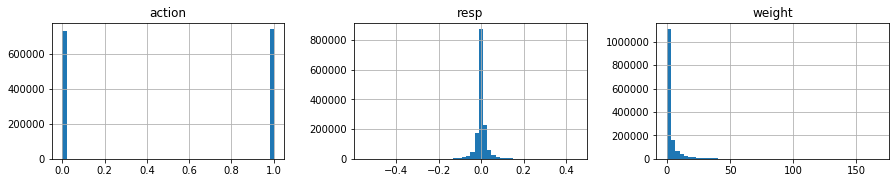

In [10]:
pd_train.hist(column=['weight', 'resp', 'action'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()

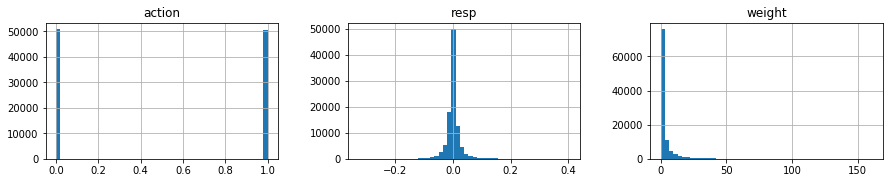

In [11]:
pd_valid.hist(column=['weight', 'resp', 'action'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()

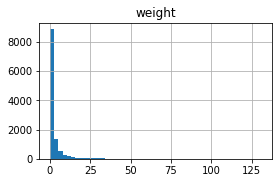

In [12]:
pd_test.hist(column=['weight'], figsize=(15, 2.5), bins=50, layout=(1, 3))
plt.show()